In [8]:
# wczytanie danych oraz bibliotek
#porządkowanie danych
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
df_comp = pd.read_csv('pogoda2_pv.csv')
df_comp['Power'] = df_comp['pv_voltage'] * df_comp['pv_current'] 
df_comp.drop(['pv_voltage','pv_current', 'battery_voltage', 'battery_current','timestamp','uv_radiation'], axis = 1, inplace = True)
df_comp.drop(['temperature','wind_speed', 'wind_dir', 'humidity','air_pressure','solar_radiation','pm2.5','luminance'], axis = 1, inplace = True)
df_comp.drop(df_comp.index[54770:132466], axis=0, inplace=True)
df_comp.drop(df_comp.index[0:39], axis=0, inplace=True)
df_comp

,data,Power
39,21-05-2021T17:00,117.315
40,21-05-2021T17:01,119.205
41,21-05-2021T17:02,119.880
42,21-05-2021T17:03,120.255
43,21-05-2021T17:04,126.320
...,...,...
54765,29-06-2021T09:56,258.950
54766,29-06-2021T09:57,251.328
54767,29-06-2021T09:58,258.600
54768,29-06-2021T09:59,261.513


In [9]:
# formatowanie datetime, frequency oraz resampling
df_comp.data=pd.to_datetime(df_comp.data, dayfirst=True)
df_comp.set_index('data', inplace=True)
df_comp

,Power
data,
2021-05-21 17:00:00,117.315
2021-05-21 17:01:00,119.205
2021-05-21 17:02:00,119.880
2021-05-21 17:03:00,120.255
2021-05-21 17:04:00,126.320
...,...
2021-06-29 09:56:00,258.950
2021-06-29 09:57:00,251.328
2021-06-29 09:58:00,258.600


In [10]:
df_compfreq = df_comp.asfreq('T', method = 'ffill')
df_compfreq

,Power
data,
2021-05-21 17:00:00,117.315
2021-05-21 17:01:00,119.205
2021-05-21 17:02:00,119.880
2021-05-21 17:03:00,120.255
2021-05-21 17:04:00,126.320
...,...
2021-06-29 09:56:00,258.950
2021-06-29 09:57:00,251.328
2021-06-29 09:58:00,258.600


In [11]:
df_compresample = df_compfreq.resample('30T').sum()
df_compresample

,Power
data,
2021-05-21 17:00:00,3752.814
2021-05-21 17:30:00,4032.787
2021-05-21 18:00:00,3371.946
2021-05-21 18:30:00,2965.362
2021-05-21 19:00:00,1151.940
...,...
2021-06-29 08:00:00,3350.734
2021-06-29 08:30:00,5187.734
2021-06-29 09:00:00,5886.454


In [12]:
df_compresample.isna().sum()

Power    0
dtype: int64

In [13]:
df_compresample.size

1859

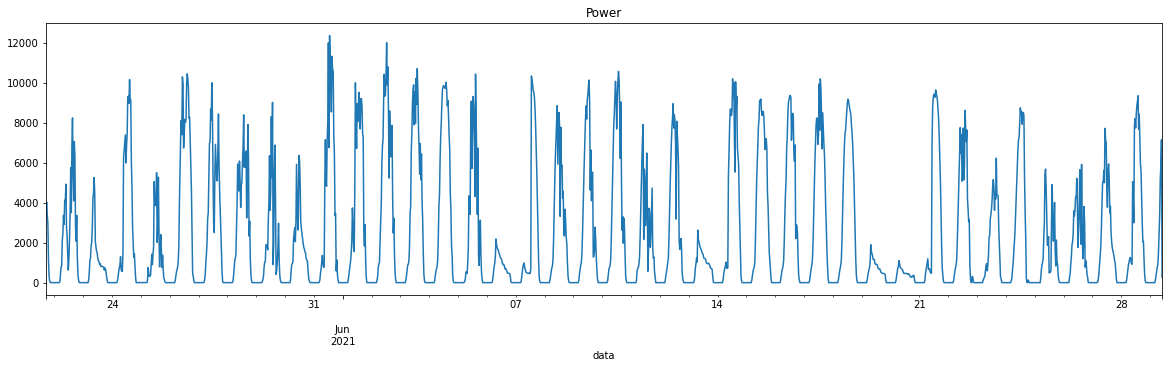

In [14]:
# dzielenie danych na test i train
size=int(len(df_compresample)*0.8)
df=df_compresample.iloc[:size]
df_test=df_compresample.iloc[size:]
df_compresample.Power.plot(figsize=(20,5))
plt.title("Power")
plt.show()

In [15]:
# Dickey Fuller test
import statsmodels.tsa.stattools as sts
sts.adfuller(df.Power)

(-11.073901685270116,
 4.482207410190013e-20,
 18,
 1468,
 {'1%': -3.434812378381713,
  '5%': -2.863510846577674,
  '10%': -2.5678192598690317},
 24532.91666436076)

<function matplotlib.pyplot.show(close=None, block=None)>

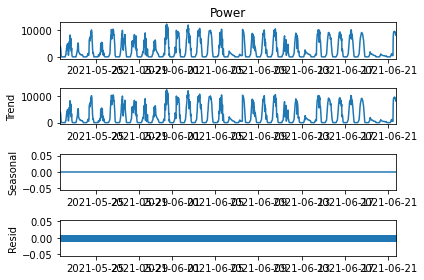

In [16]:
#Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_additive=seasonal_decompose(df.Power, model="additive",period=1)
s_dec_additive.plot()
plt.show

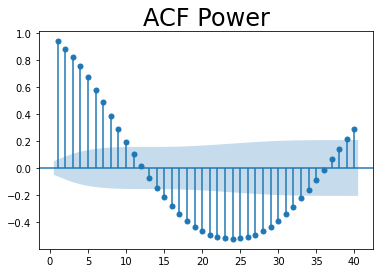

In [17]:
#Autocorrelation
sgt.plot_acf(df.Power, lags=40, zero=False)
plt.title("ACF Power", size=24)
plt.show()

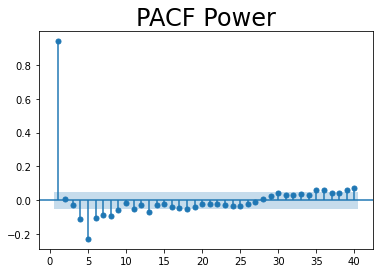

In [18]:
#Partial Autocorrelation
sgt.plot_pacf(df.Power, lags=40, zero=False, method=('ols'))
plt.title("PACF Power", size=24)
plt.show()

In [19]:
# auto arima by uzyskać rzędy dla ARMA
from pmdarima.arima import auto_arima
model_auto = auto_arima(df.Power[1:], trace=True, suppress_warnings=True)
model_auto

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=25062.877, Time=2.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=28246.710, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=25057.647, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=26888.580, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28919.250, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=25059.542, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=25059.543, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=25063.336, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25073.620, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 4.063 seconds


ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [29]:
#model
model = ARMA(df.Power, order=(6,4))
model_fit = model.fit()
model_fit.summary()

E:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Power   No. Observations:                 1487
Model:                     ARMA(6, 4)   Log Likelihood              -12450.750
Method:                       css-mle   S.D. of innovations           1046.445
Date:                Mon, 07 Mar 2022   AIC                          24925.500
Time:                        06:20:50   BIC                          24989.154
Sample:                    05-21-2021   HQIC                         24949.224
                         - 06-21-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2458.3459    150.325     16.354      0.000    2163.714    2752.978
ar.L1.Power     0.3676      0.271      1.355      0.176      -0.164       0.900
ar.L2.Power     0.9339      0.291      3.210      0.001       0.364       1.504
ar.L3.Power     0.0007      0.213      0.003      0.997      -0.417       0.418
ar.L4.Power     0.1153      0.177      0.651      0.515      -0.232       0.462
ar.L5.Power    -0.3332      0.109     -3.068      0.002      -0.546      -0.120
ar.L6.Power    -0.1638      0.055     -2.959      0.003      -0.272      -0.055
ma.L1.Power     0.4756      0.272      1.748      0.080      -0.058       1.009
ma.L2.Power    -0.4863      0.144     -3.383      0.001      -0.768      -0.205
ma.L3.Power    -0.3062      0.179     -1.709      0.087      -0.657       0.045
ma.L4.Power    -0.2440      0.123     -1.985      0.047      -0.485      -0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0191           -0.1342j            1.0279           -0.0208
AR.2            1.0191           +0.1342j            1.0279            0.0208
AR.3           -1.0539           -0.0000j            1.0539           -0.5000
AR.4           -0.2366           -1.4485j            1.4677           -0.2758
AR.5           -0.2366           +1.4485j            1.4677            0.2758
AR.6           -2.5451           -0.0000j            2.5451           -0.5000
MA.1            1.1534           -0.0000j            1.1534           -0.0000
MA.2           -1.0638           -0.0000j            1.0638           -0.5000
MA.3           -0.6723           -1.6996j            1.8277           -0.3100
MA.4           -0.6723           +1.6996j            1.8277            0.3100
-----------------------------------------------------------------------------
"""

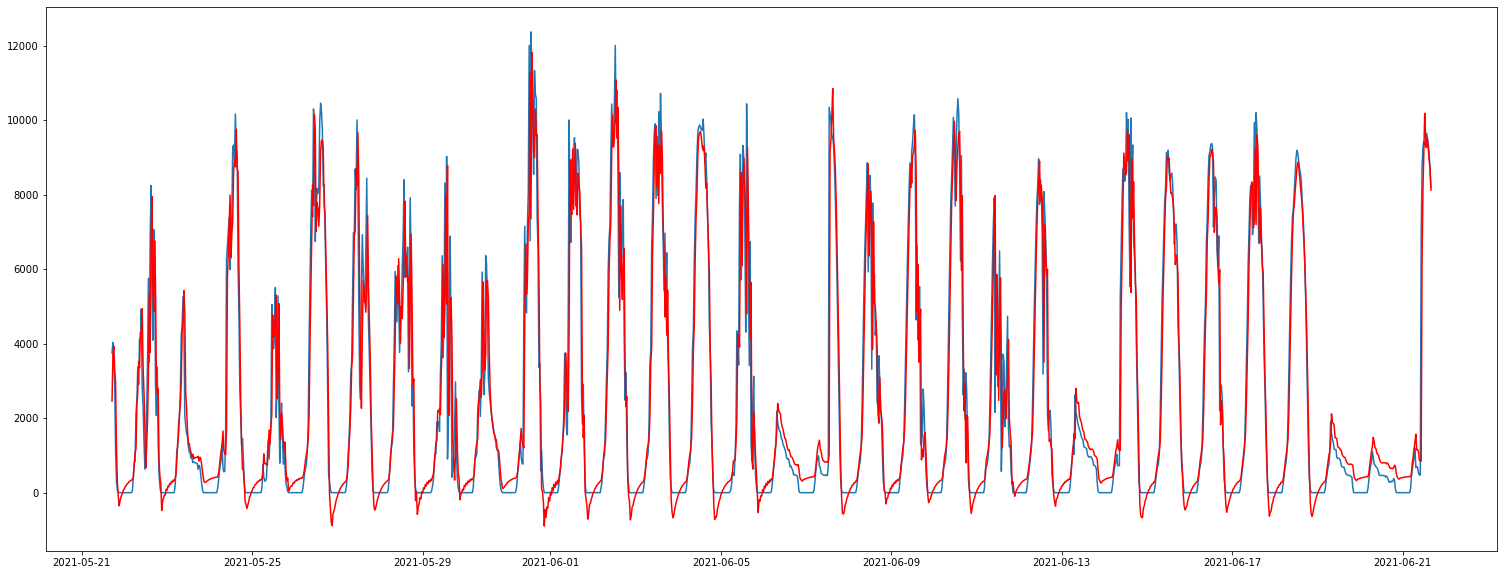

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
plt.figure(figsize=(26, 10))
plt.plot(df.Power)
plt.plot(model_fit.fittedvalues, color='red')

In [31]:
# uzyskanie predykcji, wizualizacja oraz ocena
start=len(df)
end=len(df)+len(df_test)-1

pred = model_fit.predict(start=start, end=end, typ='levels')
print (pred)

2021-06-21 16:30:00    7609.211419
2021-06-21 17:00:00    6960.297570
2021-06-21 17:30:00    6286.058280
2021-06-21 18:00:00    5553.899730
2021-06-21 18:30:00    4838.981933
                          ...     
2021-06-29 08:00:00    2458.341120
2021-06-29 08:30:00    2458.374341
2021-06-29 09:00:00    2458.405288
2021-06-29 09:30:00    2458.433547
2021-06-29 10:00:00    2458.458768
Freq: 30T, Length: 372, dtype: float64


<AxesSubplot:xlabel='data'>

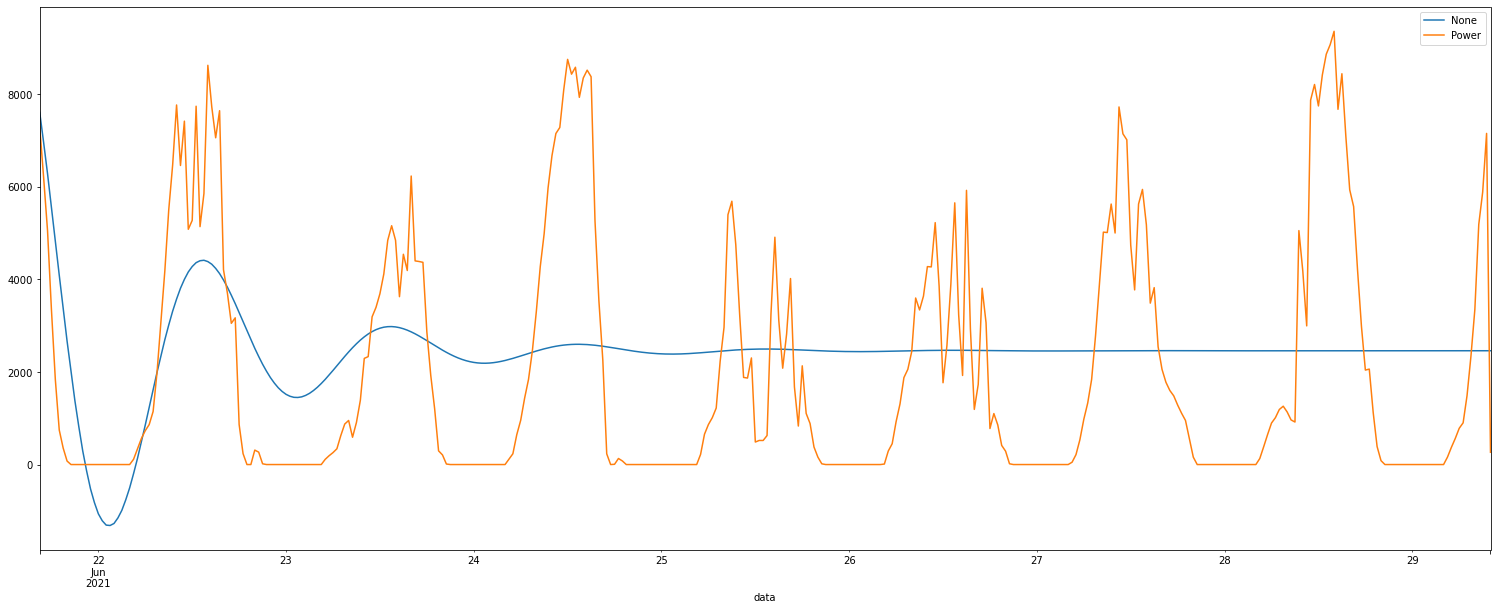

In [32]:
plt.figure(figsize=(26, 10))
pred.plot(legend=True)
df_test.Power.plot(legend=True)

In [33]:
MAE = mean_absolute_error(pred, df_test)
MDAE = median_absolute_error(pred, df_test)
MSE = mean_squared_error(pred, df_test)

print ("R2 score: " + str(r2_score(df_test, pred)))
print ("Mean Absolute Error score: " + str(MAE))
print ("Median Absolute Error score: " + str(MDAE))
print ("Mean Squared Error score: " + str(MSE))

R2 score: 0.12551597985774865
Mean Absolute Error score: 2052.1801431068066
Median Absolute Error score: 2174.3337219925006
Mean Squared Error score: 5783177.081087377


In [25]:
df_test['Power'].mean()

2018.798830645162

In [26]:
from math import sqrt
rmse=sqrt(MSE)
print(rmse)

2431.6374977655228


In [27]:
pred.head(10)

2021-06-21 16:30:00    7603.327672
2021-06-21 17:00:00    6969.348936
2021-06-21 17:30:00    6295.717454
2021-06-21 18:00:00    5595.843832
2021-06-21 18:30:00    4882.827254
2021-06-21 19:00:00    4169.255056
2021-06-21 19:30:00    3467.021992
2021-06-21 20:00:00    2787.171089
2021-06-21 20:30:00    2139.757532
2021-06-21 21:00:00    1533.736571
Freq: 30T, dtype: float64

In [28]:
df_test.head(10)

,Power
data,
2021-06-21 16:30:00,7301.437
2021-06-21 17:00:00,6204.570
2021-06-21 17:30:00,5056.202
2021-06-21 18:00:00,3348.306
2021-06-21 18:30:00,1833.321
2021-06-21 19:00:00,745.790
2021-06-21 19:30:00,356.884
2021-06-21 20:00:00,75.246
2021-06-21 20:30:00,0.000
